# `Combined` Model generalizable

Generate another combined model but exclude 10 samples from training such that we get a set of totally unseen data

In [1]:
# Sconda conda activate tensorflow2; cd /mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/deeplift_analysis/; python

In [2]:
%load_ext lab_black

In [3]:
import tensorflow

tensorflow.__version__

'2.4.0'

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.initializers import GlorotUniform

from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras import backend as K

import sys
import pkg_resources
import random

## Declare some constants

In [5]:
train = True
model_name = "Generalizable Model"
model_name_file = model_name.lower().replace(" ", "_")
keras_model_json = f"./{model_name_file}_model.json"
keras_model_weights = f"./{model_name_file}_weights.h5"
OutputLayer = "sigmoid"
model_name_file

'generalizable_model'

### Loading Datasets

In [6]:
x_all_data = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_x.npy"
)
y_all_data = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_y.npy"
)
m_all_data = pd.read_parquet(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_m.parquet"
)
sample_names = pd.read_csv(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/filtered_files_surnames.csv",
    header=None,
)[7].tolist()

samples_in_dataset = int(m_all_data.groupby("gene").size().mean())
assert m_all_data.shape[0] == x_all_data.shape[1] == y_all_data.shape[0]
assert samples_in_dataset == len(sample_names)

print(
    f"""
samples: {len(sample_names)}
X shape: {x_all_data.shape}
Y shape: {y_all_data.shape}
M shape: {m_all_data.shape}
"""
)


samples: 49
X shape: (230, 1063153)
Y shape: (1063153,)
M shape: (1063153, 6)



In [7]:
genes_per_sample = m_all_data.shape[0] // samples_in_dataset
m_all_data["sample_name"] = [x for x in sample_names for _ in range(genes_per_sample)]
m_all_data.head()

,gene,category,binary_category,chr,order,tpm,sample_name
0,Baat,Low,0,chr4,1,0.000000,mm10_Bcell_Activated_24_Rep1
1,Hyi,High,1,chr4,2,8.015400,mm10_Bcell_Activated_24_Rep1
2,Akirin1,High,1,chr4,3,50.077466,mm10_Bcell_Activated_24_Rep1
3,Lrrc69,Low,0,chr4,4,0.000000,mm10_Bcell_Activated_24_Rep1
4,Fam159a,Low,0,chr4,5,0.000000,mm10_Bcell_Activated_24_Rep1


In [8]:
# randomly select 10 samples to exclude
excluded_samples = random.sample(sample_names, 10)
# excluded_samples = [
#     "mm10_WholeBrain_Rep1",
#     "mm10_iNK_T_Cell_Rep2",
#     "mm10_E14_mESC_Rep3",
#     "mm10_E13_Frontal_Cortex_Rep1",
#     "mm10_V6.5_mESC_Rep10",
#     "mm10_Naive_T_Cell_Rep2",
#     "mm10_CD4_SinglePositive_Tcell_Rep1",
#     "mm10_MEF_Rep3",
#     "mm10_Hematopoietic_Stem_Cells_Rep1",
#     "mm10_Regulatory_T_Cell_Rep2",
# ]

In [9]:
# randomly select 2 chromosomes to exclude
# 1 for developing model
# 1 for testing in unseen data
sex_chr = ["chrY", "chrX"]
excluded_chrom = random.sample(
    list(set(m_all_data.chr.unique().tolist()) - set(sex_chr)), 2
)
# excluded_chrom = ["chr14", "chr16"]

In [9]:
# Generate the used data subset
# Generate the training, Dev, and test from data subset
# testing flag: samples excluded + chr for testing
# dev flag: samples included + chr for dev
# train flag: samples included + chr not for dev/test
excluded_samples_mask = m_all_data.sample_name.isin(excluded_samples)
chr_dev_mask = m_all_data.chr.isin([excluded_chrom[0]])
chr_test_mask = m_all_data.chr.isin([excluded_chrom[1]])
chr_train_mask = ~m_all_data.chr.isin(excluded_chrom)

test_mask = excluded_samples_mask & chr_test_mask
dev_mask = (~excluded_samples_mask) & chr_dev_mask
train_mask = (~excluded_samples_mask) & chr_train_mask

In [10]:
# Assert no overlapping masks
assert sum((test_mask & dev_mask) & train_mask) == 0

# Assert chromosome masks make sense
assert all(chr_dev_mask | chr_test_mask | chr_train_mask)

In [11]:
# Train
X = x_all_data[:, train_mask].T
Y = y_all_data[train_mask].reshape(-1, 1)

# Dev
X_dev = x_all_data[:, dev_mask].T
Y_dev = y_all_data[dev_mask].reshape(-1, 1)

# Test
X_test = x_all_data[:, test_mask].T
Y_test = y_all_data[test_mask].reshape(-1, 1)

print(
    f"""
X_train shape: {X.shape}
Y_train shape: {Y.shape}

X_dev shape: {X_dev.shape}
Y_dev shape: {Y_dev.shape}\n

X_test shape: {X_test.shape}
Y_test shape: {Y_test.shape}
"""
)


X_train shape: (791852, 230)
Y_train shape: (791852, 1)

X_dev shape: (29826, 230)
Y_dev shape: (29826, 1)


X_test shape: (7394, 230)
Y_test shape: (7394, 1)



## Sequential-style FCDNN

### Function to remove layer that is causing issues:

In [12]:
# Load the original JSON data
def json_remove_input_layer(json_file):
    # Read json
    with open(json_file, "r") as file:
        data = json.load(file)
        file.close()
    # Check if it has the problem and delete
    if (
        data["config"]["layers"]
        and data["config"]["layers"][0]["class_name"] == "InputLayer"
    ):
        del data["config"]["layers"][0]
        print("deleted 'InputLayer' layer config")
        # Save the modified data back to a new JSON file
        with open(json_file, "w") as file:
            json.dump(data, file, indent=4)
            file.close()
    else:
        print("Model does not contain 'InputLayer' in layer config")


# Remove the first layer from the 'layers' list within the 'config' key

### Function to make Keras model

In [13]:
# Make this a function to get a cleaner code:
def make_keras_model(X):
    keras_model = Sequential()
    keras_model.add(
        Dense(
            200,
            activation="relu",
            name="1",
            input_dim=X.shape[1],
            kernel_initializer=GlorotUniform(),
        )
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(100, activation="relu", name="2", kernel_initializer=GlorotUniform())
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(50, activation="relu", name="3", kernel_initializer=GlorotUniform())
    )
    keras_model.add(
        Dense(
            1, activation="sigmoid", name="Output", kernel_initializer=GlorotUniform()
        )
    )
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return keras_model

### Train Model

In [22]:
clean_data_model = make_keras_model(X)
history = clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=1000)
# serialize model to JSON
model_json = clean_data_model.to_json()
with open(keras_model_json, "w") as json_file:
    json_file.write(model_json)
    json_file.close()
# Load back for formatting
json_remove_input_layer(keras_model_json)
# serialize weights to HDF5
clean_data_model.save_weights(keras_model_weights)


  1/933 [..............................] - ETA: 10s - loss: 0.2552 - accuracy: 0.9688

933/933 [==============================] - 1s 529us/step - loss: 0.4620 - accuracy: 0.7863
deleted 'InputLayer' layer config


In [23]:
def test_and_auc(
    keras_model,
    X_dev,
    Y_dev,
    save_prob: bool = False,
    prin_auc_plot: bool = True,
    sample_name="New Model",
):
    sample_file_name = sample_name.lower().replace(" ", "_")
    out_file = f"./roc_curve_{sample_file_name}.png"
    ProbableValues = keras_model.predict(X_dev)
    Obs = pd.Series(Y_dev.flatten().astype(int))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Side2Prob = pd.concat([Obs, Pred, Prob], axis=1)
    Side2Prob.columns = ["Observed", "Predicted", "Probability"]
    if save_prob:
        Side2Prob.to_feather(
            f"./Probabilities_Keras_{sample_file_name}_e60_L200_100_50_1.feather"
        )
        Side2Prob.to_csv(
            f"./Probabilities_Keras_{sample_file_name}_e60_L200_100_50_1.csv",
            index=False,
        )

    fpr, tpr, _ = roc_curve(Obs, Prob)
    auc_score = roc_auc_score(Obs, Prob)

    print(
        """
Accuracy:    %.4f
Precision:   %.4f
Recall:      %.4f
F1 score:    %.4f
AUC Score:   %.4f
"""
        % (
            preds[1],
            precision_score(Obs, Pred),
            recall_score(Obs, Pred),
            f1_score(Obs, Pred),
            auc_score,
        )
    )
    if prin_auc_plot:
        font_name = "Nimbus Roman"
        # downsample points to plot if too large
        num_points = min(len(tpr), 1000)
        fpr_interp = np.linspace(0, 1, num_points)
        tpr_interp = np.interp(fpr_interp, fpr, tpr)
        plt.rcParams["font.family"] = "Nimbus Roman"

        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Create the plot with Seaborn
        plt.figure(figsize=(8, 6))
        sns.lineplot(
            x=fpr_interp,
            y=tpr_interp,
            label=f"Model (AUC = {auc_score:.2f})",
            linewidth=2,
        )
        ax = sns.lineplot(
            x=[0, 1],
            y=[0, 1],
            linestyle="--",
            label="No learning",
            color="tab:gray",
        )

        # Customizing the plot to make it more suitable for publication
        title_fontsize = 16 * 1.3  # 2x the base size for labels
        label_fontsize = 16 * 1.5  # 2x the base size for labels
        tick_fontsize = 12 * 2  # 2x the base size for ticks
        ax.set_title(
            f"ROC Curve: {sample_name}", fontsize=title_fontsize, fontname=font_name
        )
        ax.set_xlabel(
            "False Positive Rate (FPR)", fontsize=label_fontsize, fontname=font_name
        )
        ax.set_ylabel(
            "True Positive Rate (TPR)", fontsize=label_fontsize, fontname=font_name
        )
        plt.xticks(fontsize=tick_fontsize, fontname=font_name)
        plt.yticks(fontsize=tick_fontsize, fontname=font_name)
        plt.legend(loc="best", fontsize=14)
        plt.tight_layout()
        # Save the plot
        plt.savefig(out_file, dpi=300)
        # Show the plot
        plt.show()

    return Side2Prob

### Get AUC metrics per sample

In [34]:
def get_auc_f1(
    keras_model,
    X_test,
    Y_test,
):

    ProbableValues = keras_model.predict(X_test)
    Obs = pd.Series(Y_test.flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    auc_score = round(roc_auc_score(Obs, Prob), 4)
    f1 = round(f1_score(Obs, Pred), 4)

    return auc_score, f1

In [13]:
data_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B"

sample_names = pd.read_csv(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/filtered_files_surnames.csv",
    header=None,
)[7].tolist()

# output results variable
auc_results = []

# Load trained model:
# keras_model_json
# serialize weights to HDF5
# keras_model_weights

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

chr_test_mask = m_all_data.chr.isin([excluded_chrom[1]])


2024-02-28 22:15:28.755800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
auc_results = []
f1_results = []
for i, sample in enumerate(excluded_samples):
    print(sample)
    excluded_sample_mask = m_all_data.sample_name.isin([sample])
    test_mask = excluded_sample_mask & chr_test_mask
    X_test = x_all_data[:, test_mask].T
    Y_test = y_all_data[test_mask].reshape(-1, 1)
    auc, f1 = get_auc_f1(keras_model, X_test, Y_test)
    auc_results.append(auc)
    f1_results.append(f1)

mm10_WholeBrain_Rep1
mm10_iNK_T_Cell_Rep2
mm10_E14_mESC_Rep3
mm10_E13_Frontal_Cortex_Rep1
mm10_V6.5_mESC_Rep10
mm10_Naive_T_Cell_Rep2
mm10_CD4_SinglePositive_Tcell_Rep1
mm10_MEF_Rep3
mm10_Hematopoietic_Stem_Cells_Rep1
mm10_Regulatory_T_Cell_Rep2


In [33]:
for i, j in zip(excluded_samples, map(str, auc_results)):
    print(i, j)

mm10_WholeBrain_Rep1 0.8198
mm10_iNK_T_Cell_Rep2 0.8693
mm10_E14_mESC_Rep3 0.8245
mm10_E13_Frontal_Cortex_Rep1 0.9236
mm10_V6.5_mESC_Rep10 0.8446
mm10_Naive_T_Cell_Rep2 0.8629
mm10_CD4_SinglePositive_Tcell_Rep1 0.8465
mm10_MEF_Rep3 0.8409
mm10_Hematopoietic_Stem_Cells_Rep1 0.8316
mm10_Regulatory_T_Cell_Rep2 0.8904


In [38]:
for i, j in zip(excluded_samples, map(str, f1_results)):
    print(i, j)

mm10_WholeBrain_Rep1 0.7318
mm10_iNK_T_Cell_Rep2 0.786
mm10_E14_mESC_Rep3 0.7207
mm10_E13_Frontal_Cortex_Rep1 0.8363
mm10_V6.5_mESC_Rep10 0.7831
mm10_Naive_T_Cell_Rep2 0.8071
mm10_CD4_SinglePositive_Tcell_Rep1 0.747
mm10_MEF_Rep3 0.7497
mm10_Hematopoietic_Stem_Cells_Rep1 0.7675
mm10_Regulatory_T_Cell_Rep2 0.8238


In [27]:
round(pd.DataFrame(auc_results).describe(), 4)

,0
count,10.0000
mean,0.8554
std,0.0322
min,0.8198
25%,0.8339
50%,0.8456
75%,0.8677
max,0.9236


In [39]:
round(pd.DataFrame(f1_results).describe(), 4)

,0
count,10.0000
mean,0.7753
std,0.0389
min,0.7207
25%,0.7477
50%,0.7753
75%,0.8018
max,0.8363


### Plot metrics


Accuracy:    0.7863
Precision:   0.7813
Recall:      0.7518
F1 score:    0.7663
AUC Score:   0.8631



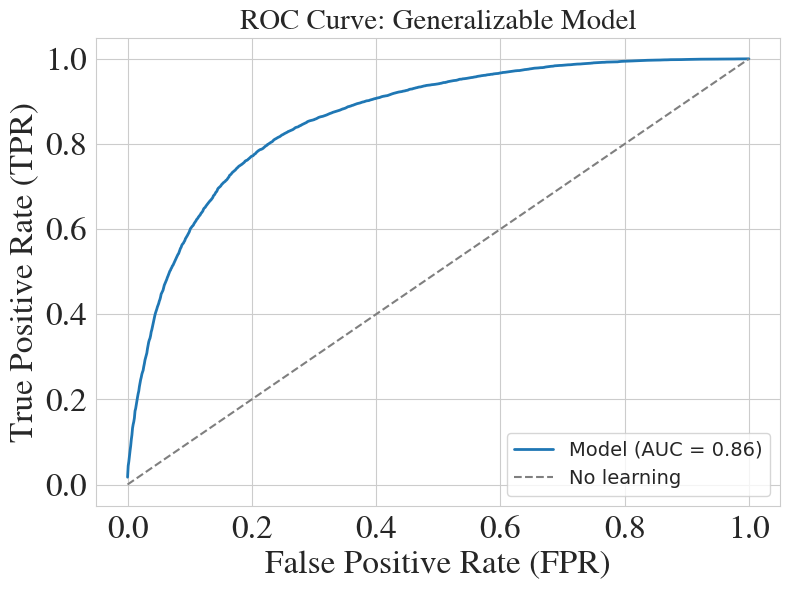

In [24]:
if train:
    _ = test_and_auc(clean_data_model, X_dev, Y_dev, sample_name="Generalizable Model")
# Accuracy:    0.7927
# Precision:   0.8175
# Recall:      0.7884
# F1 score:    0.8027
# AUC Score:   0.8703

## Test Loading model


Accuracy:    0.7863
Precision:   0.7813
Recall:      0.7518
F1 score:    0.7663
AUC Score:   0.8631



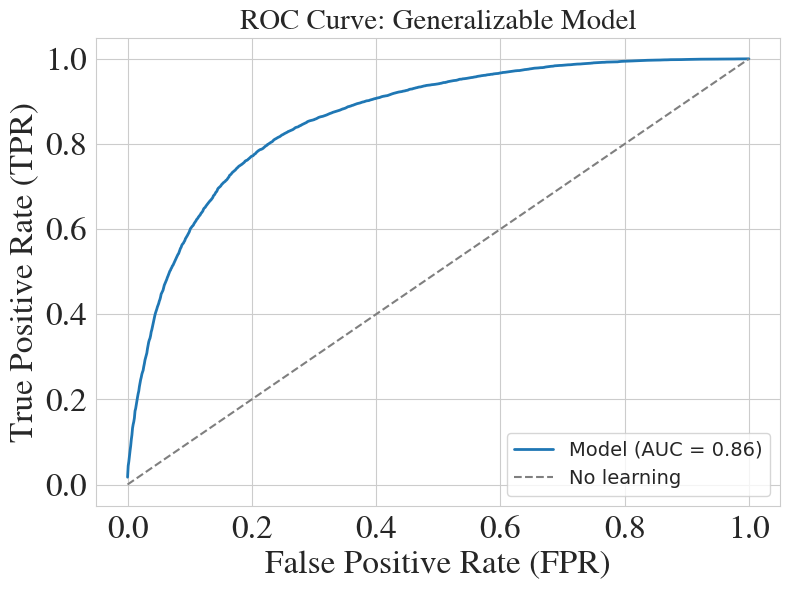

In [25]:
# load the keras model
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
Side2Prob = test_and_auc(
    keras_model,
    X_dev,
    Y_dev,
    prin_auc_plot=True,
    save_prob=True,
    sample_name="Generalizable Model",
)

In [35]:
Side2Prob.to_csv(
    f"./Probabilities_Keras_CleanSamples_e60_L200_100_50_1.csv", index=False
)

## Obtain the value that generates a neutral response

In [36]:
# Initialize variables
min_diff = float("inf")
neutral_value = 0

# Prepare the entire range of input values
input_values = np.arange(-10, 10, 0.01)
input_array = np.full(
    (input_values.size, 230), input_values.reshape(-1, 1), dtype=np.float32
)

# Predict for all input values in a single pass
sigma_values = keras_model.predict(input_array, batch_size=200).flatten()
diffs = np.abs(sigma_values - 0.5)

# Find the value that produces the sigma closest to 0.5
min_diff_idx = np.argmin(diffs)
min_diff = diffs[min_diff_idx]
neutral_value = input_values[min_diff_idx]

# Predict using the neutral value found
sigma_value = float(
    keras_model.predict(np.full((1, 230), neutral_value), batch_size=200)
)

# Output results
print(f"Neutral Reference: {neutral_value:.4f}\nSigma: {sigma_value}")

# Prepare the neutral reference input array for further use
NeuRef = np.full((1, 230), neutral_value, dtype=np.float32)

Neutral Reference: 3.8600
Sigma: 0.4997701048851013


# Print packages used

In [37]:
def get_imported_packages_with_versions():
    imported_packages = set(
        [module.split(".")[0] for module in sys.modules.keys() if module.split(".")[0]]
    )
    imported_packages_with_versions = {}

    for pkg in imported_packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            imported_packages_with_versions[pkg] = version
        except (
            pkg_resources.DistributionNotFound,
            pkg_resources.ExtractionError,
            pkg_resources.VersionConflict,
            Exception,
        ):
            # Skip packages that cause issues
            pass

    return imported_packages_with_versions


imported_packages_with_versions = get_imported_packages_with_versions()

# Print the package names and their versions
for pkg, version in imported_packages_with_versions.items():
    print(f"{pkg}: {version}")

setuptools: 69.0.3
seaborn: 0.12.2
black: 24.1.1
keras_preprocessing: 1.1.2
executing: 2.0.1
prompt_toolkit: 3.0.42
requests: 2.31.0
matplotlib_inline: 0.1.6
flatbuffers: 1.12
idna: 3.6
termcolor: 2.4.0
stack_data: 0.6.2
ptyprocess: 0.7.0
jupyter_core: 5.7.1
opt_einsum: 3.3.0
pickleshare: 0.7.5
six: 1.16.0
tensorboard: 2.4.1
pyparsing: 3.1.1
pytz: 2024.1
scipy: 1.9.3
importlib_metadata: 7.0.1
traitlets: 5.14.1
urllib3: 2.2.0
parso: 0.8.3
IPython: 8.12.2
jupyter_client: 8.6.0
joblib: 1.3.2
zipp: 3.17.0
keras: 2.4.3
certifi: 2024.2.2
cffi: 1.16.0
psutil: 5.9.8
packaging: 23.2
jedi: 0.19.1
tomli: 2.0.1
pure_eval: 0.2.2
pygments: 2.17.2
brotli: 1.1.0
pandas: 1.3.5
cycler: 0.12.1
pathspec: 0.12.1
decorator: 5.1.1
click: 8.1.7
tensorflow: 2.4.0
pexpect: 4.9.0
tornado: 6.4
backcall: 0.2.0
asttokens: 2.4.1
debugpy: 1.8.1
typing_extensions: 4.9.0
threadpoolctl: 3.2.0
pyarrow: 3.0.0
wrapt: 1.16.0
platformdirs: 4.2.0
mypy_extensions: 1.0.0
charset_normalizer: 3.3.2
h5py: 2.10.0
kiwisolver: 1.4.5


In [38]:
json_remove_input_layer("./clean_samples_model_mac.json")

Model does not contain 'InputLayer' in layer config
